## Notebook - fredraak.com - There's levels to this ...

### Imports

In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from scipy.stats import wilcoxon
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.metrics import r2_score
from hyperopt import hp

from utility_fr import mdl_hypopt, mdl_fit_pred, mdl_eval, get_xy_data, kfold_win, rmse

plt.rcParams.update({'font.size': 13})

### Pipeline and Utility Functions

In [2]:
def pred_eval_pipe(data_dic, set_split, mdl_set, scaler='MinMax', rstate=0):

    # Prepare ML Data
    data_dic = prep_ML_data(data_dic, set_split, scaler, rstate)

    # Train Models for Each Data
    mdl_set, rslt_all = train_models(data_dic, mdl_set)

    # Wilcoxon Test -- Comparison Against Best Model
    rslt_stats = stats_check(rslt_all)

    return data_dic, mdl_set, rslt_all, rslt_stats


def prep_ML_data(data_dic, set_split, scaler, rstate=0):
    """
    Prepare Data for Machine Learning (Prediction)
    """

    # Scaling & Reshaping Data
    def scale_data(data, scale):
        return scale.transform(data.reshape(-1, 1)).reshape(data.shape)

    if not isinstance(set_split, list):
        set_split = [0.2, 0.2]

    for d_name in data_dic.keys():

        # Get Data & Settings
        data_ = data_dic[d_name]["data"]
        length = data_dic[d_name]["set"]["len"]
        lead = data_dic[d_name]["set"]["horizon"]

        # Prepare Data for ML
        X, y = get_xy_data(data_, length=length, lead=lead)

        # Train & Test Data
        n_test = int(len(X)*set_split[0])
        X_train, X_test = X[:-n_test], X[-n_test:]
        y_train, y_test = y[:-n_test], y[-n_test:]

        # Train & Validation Data
        n_train = int(len(X_train)*(1-set_split[1]))
        X_val, X_train = X_train[n_train:], X_train[:n_train]
        y_val, y_train = y_train[n_train:], y_train[:n_train]

        # Scaler
        if scaler == 'MinMax':
            data_dic[d_name]["ML"]["scaler"] = MinMaxScaler()
        else:
            data_dic[d_name]["ML"]["scaler"] = StandardScaler()

        data_dic[d_name]["ML"]["scaler"].fit(np.c_[X_train, y_train].reshape(-1, 1))
        scaler_ = data_dic[d_name]["ML"]["scaler"]

        # Update Data Dictionary
        data_dic[d_name]["ML"]["X_train"] = scale_data(X_train, scaler_)
        data_dic[d_name]["ML"]["y_train"] = scale_data(y_train, scaler_)

        data_dic[d_name]["ML"]["X_test"] = scale_data(X_test, scaler_)
        data_dic[d_name]["ML"]["y_test"] = scale_data(y_test, scaler_)

        data_dic[d_name]["ML"]["X_val"] = scale_data(X_val, scaler_)
        data_dic[d_name]["ML"]["y_val"] = scale_data(y_val, scaler_)

    return data_dic


def train_models(data_dic, mdl_set, k=10, seg_size=0.3, time_opt=120):

    rslt_all = {}  # Store Results Here
    for id_, d_name in enumerate(data_dic.keys()):

        rslt_all[d_name] = {}

        # Get ML Data
        data_ML = data_dic[d_name]["ML"]

        # Get Indices for k Test Data Segments
        id_kfold = kfold_win(data_ML["X_test"].shape[0], k, seg_size)

        rslt_data = {}
        for mdl_name in mdl_set.keys():
            mdl_set[mdl_name][d_name] = {}

            if mdl_set[mdl_name]["opti"]:  # Optimize Model
                para_best = mdl_hypopt(mdl_name, mdl_set[mdl_name]["set"],
                                       data_ML, verb=True, time_stop=time_opt)

                mdl_set[mdl_name]["best"] = para_best
            else:
                para_best = mdl_set[mdl_name]["set"]

            # Evaluate Accuracy for k Data Segments
            rslt_ = [mdl_eval(para_best, mdl_name, data_ML, 'test', ids) for ids in id_kfold]

            # Get & Store Predictions
            y_pred = mdl_fit_pred(para_best, mdl_name, data_ML, 'test')[1]
            mdl_set[mdl_name][d_name]["y_pred"] = y_pred

            # Store Evaluation Results
            rslt_data[mdl_name] = np.hstack(rslt_)

        rslt_all[d_name] = rslt_data

    return mdl_set, rslt_all


def stats_check(rslt_all, p_thresh=0.01):

    stats_all = {}  # Store Results Here
    for d_name in data_dic.keys():

        rslt_ = pd.DataFrame(rslt_all[d_name])
        mdl_list = list(rslt_)

        # Lowest Mean-Error Model
        mdl_best = mdl_list[rslt_.mean(0).argmin()]

        # Wilcoxon Signed-Rank Test Between Best Model and Other Models
        less_test = []
        for md in mdl_list:

            if md != mdl_best:
                wtest_ = wilcoxon(rslt_[mdl_best], rslt_[md], alternative="less")[1]
                w_test_res = "Beaten" if wtest_ <= p_thresh else "Draw"
                less_test.append(w_test_res)
            else:
                less_test.append("Best")

        d_rslt = dict(zip(mdl_list, less_test))

        stats_all[d_name] = d_rslt

    return pd.DataFrame(stats_all)

### Create/Load Data

In [3]:
# Data Settings
np.random.seed(0)
n_data = 2000


# (1) Gaussian Data
data_normal = np.random.normal(2, 1, n_data)


# (2) AR(2) Data
A = np.array([  # System Matrix
    [0.7, -0.6],
    [0.85, 0.7],
])

xs = [np.array([-0.5, 0.5])]
for it in range(1, n_data//2):
    xs.append(np.matmul(A, xs[it-1]))

data_ar = np.vstack(xs)[:, 0] + np.random.normal(0, 0.2, n_data//2)


# (3) Nonlinear Data

data_cdv = np.load("x1.npy")
data_cdv = data_cdv[:n_data*4][::3]

data_normal.shape, data_ar.shape, data_cdv.shape

((2000,), (1000,), (2667,))

### Model/Data Settings

In [4]:
set_split = [0.2, 0.2]  # [#test/#data, #validation/#train]

# List of Data + Settings
data_dic = {
    "gauss": {"data": data_normal, "ML": {}, "set": {"len": 30, "horizon": 5}},
    "ar": {"data": data_ar, "ML": {}, "set": {"len": 10, "horizon": 5}},
    "nonlinear": {"data": data_cdv, "ML": {}, "set": {"len": 32, "horizon": 5}},
}

# Model Settings
set_mean = {'nsteps': 30}
set_trend = {"ndiff": hp.choice("ndiff", np.arange(1, 5))}
set_ar = {}
set_lgbm = {
    "n_estimators": hp.choice("n_estimators", np.logspace(1, np.log10(200), 15, dtype=int)),
    "num_leaves": hp.choice("num_leaves", np.unique(np.logspace(np.log10(2), np.log10(100), 20, dtype=int))),
    "max_depth": hp.choice("max_depth", np.arange(1, 10)),
    "min_data_in_leaf": hp.choice("min_data_in_leaf", np.unique(np.logspace(1, np.log10(30), 10, dtype=int))),
    "subsample": hp.choice("subsample", np.arange(7, 11)/10),
    "subsample_freq": hp.choice("subsample_freq", np.arange(5)),
    "max_bin": hp.choice("max_bin", np.logspace(1, np.log10(255), 20, dtype=int)),
    "random_state": hp.choice("random_state", [0]),
}
set_FCNN = {
    "out": 1,  # 1 if prediction of scalar
    "n_layers": hp.choice("n_layers", [2, 3, 4, 5]),
    "le_y0": hp.choice("le_y0", np.arange(16, 40, 8)),
    "activ": hp.choice("activ", ["relu", "tanh", "linear"]),
    'mid_act_only': hp.choice("mid_act_only", [True, False]),
    "bias": hp.choice("bias", [True, False]),
    "lr": hp.choice("lr", [0.01]),
    "n_epoch": hp.choice("n_epoch", [100]),
    "bSize": hp.choice("bSize", [32]),
    "random_state": hp.choice("random_state", [0]),
}

# List of Models to Train & Evaluate
mdl_set = {
    "mdl_naive": {"set": {}, "opti": False},
    "mdl_mean": {"set": set_mean, "opti": False},
    "mdl_trend": {"set": set_trend, "opti": True},
    "mdl_ar": {"set": {}, "opti": False},
    "mdl_lgbm": {"set": set_lgbm, "opti": True},
    "mdl_FCNN": {"set": set_FCNN, "opti": True},
}

### Run Training/Prediction

In [5]:
data_dic_, mdl_set_, rslt_all, rslt_stats = pred_eval_pipe(data_dic, set_split, mdl_set)
rslt_mean = pd.DataFrame(rslt_all).applymap(lambda x: float(x.mean()))
rslt_mean.round(3)

  4%|▎         | 35/1000 [02:00<55:20,  3.44s/trial, best loss: 0.10239253763387023]  


,gauss,ar,nonlinear
mdl_naive,0.231,0.363,0.203
mdl_mean,0.159,0.220,0.323
mdl_trend,0.260,0.451,0.194
mdl_ar,0.160,0.094,0.172
mdl_lgbm,0.159,0.086,0.031
mdl_FCNN,0.157,0.085,0.083


### Plot Results

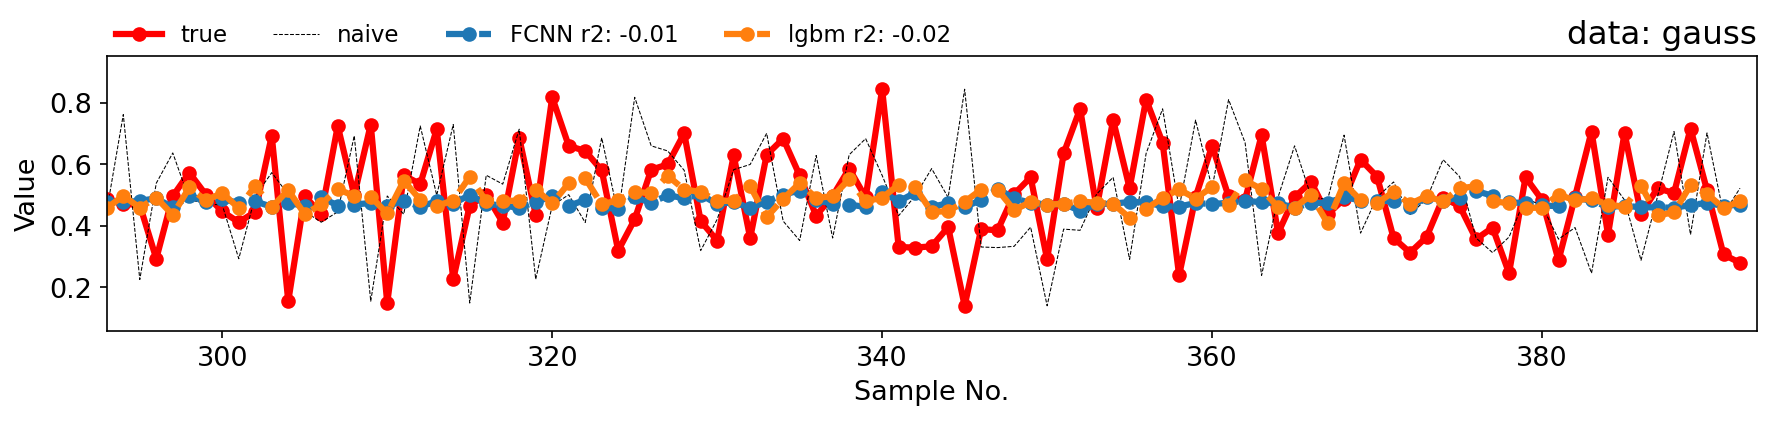

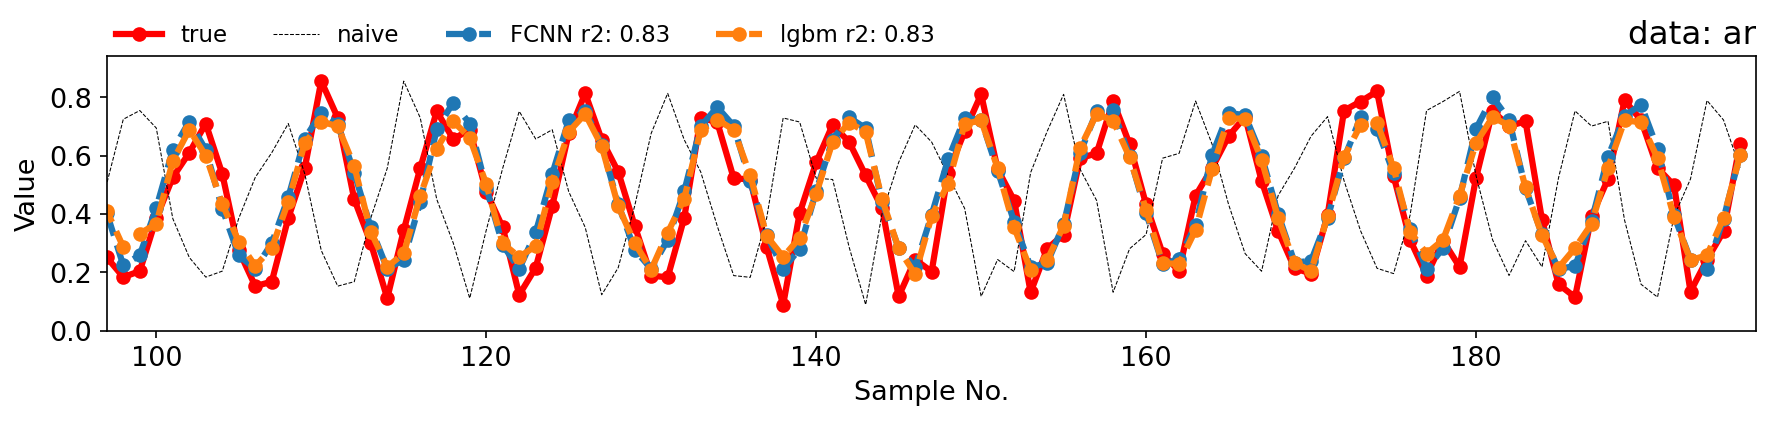

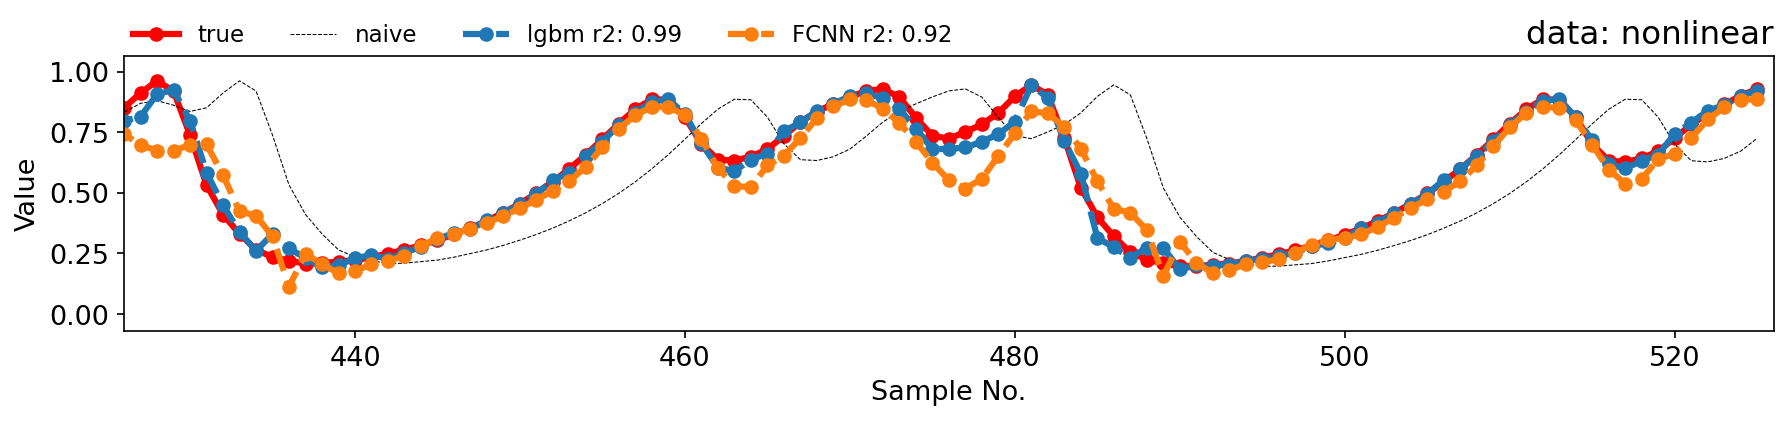

In [6]:
if rslt_mean.shape[1] > 1:
    rslt_asort = np.argsort(rslt_mean.values, axis=0)
else:
    rslt_asort = np.atleast_2d(np.argsort(rslt_mean.values.flatten(), axis=0)).T
mdls_ = np.array(rslt_mean.index)
best_n = 2

for id_, dname in enumerate(data_dic.keys()):
    y_true = data_dic_[dname]['ML']['y_test']

    plt.figure(dpi=150, figsize=(12, 3))
    plt.plot(y_true, 'r-o', linewidth=3, label='true')
    plt.plot(mdl_set_['mdl_naive'][dname]["y_pred"], 'k--', linewidth=0.5, label='naive')
    r2_all, rmse_all = [], []
    for md in mdls_[rslt_asort[:, id_][:best_n]]:
        y_pred = mdl_set_[md][dname]["y_pred"]

        r2_ = r2_score(y_true, y_pred)

        plt.plot(y_pred, 'o--', linewidth=3, label=f"{md[4:]} r2: {round(r2_, 2)}")

    plt.title(f"data: {dname}", loc='right')
    plt.xlim(len(y_pred)-100, len(y_pred))
    plt.legend(frameon=False, loc=[0, 1], ncol=best_n+2, fontsize=11)
    plt.xlabel('Sample No.')
    plt.ylabel('Value')
    plt.tight_layout()

In [7]:
rslt_stats

,gauss,ar,nonlinear
mdl_naive,Beaten,Beaten,Beaten
mdl_mean,Beaten,Beaten,Beaten
mdl_trend,Beaten,Beaten,Beaten
mdl_ar,Beaten,Beaten,Beaten
mdl_lgbm,Draw,Draw,Best
mdl_FCNN,Best,Best,Beaten


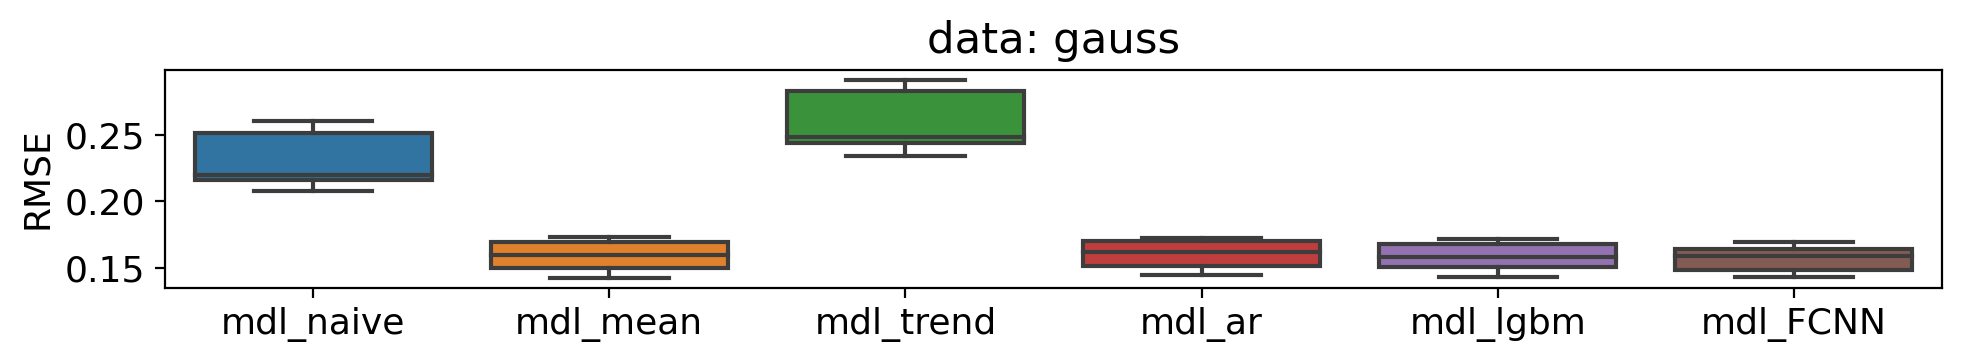

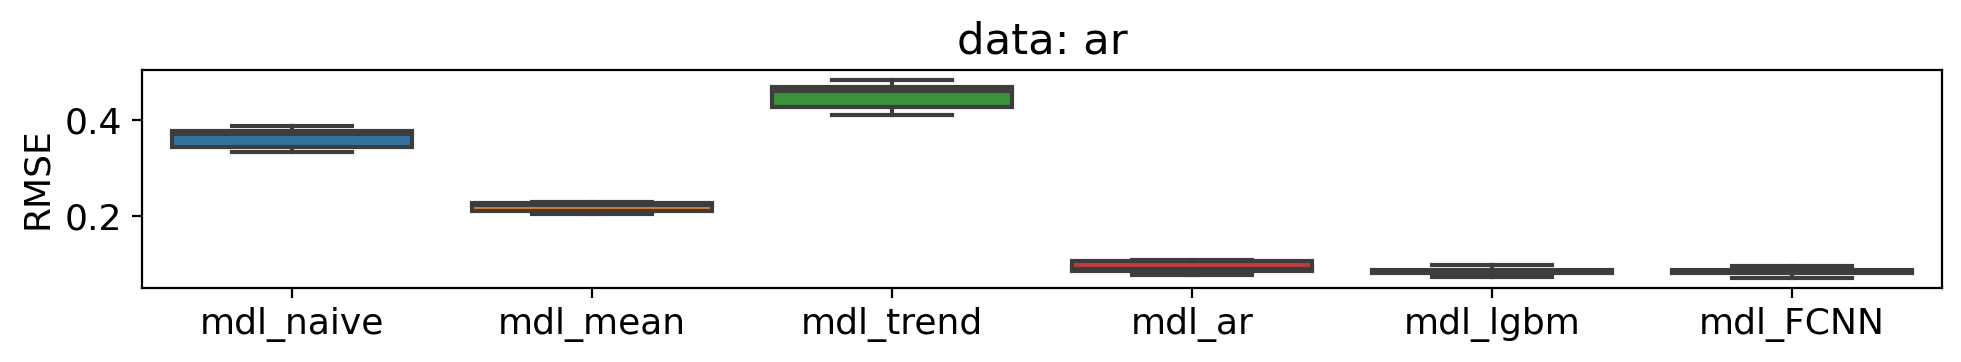

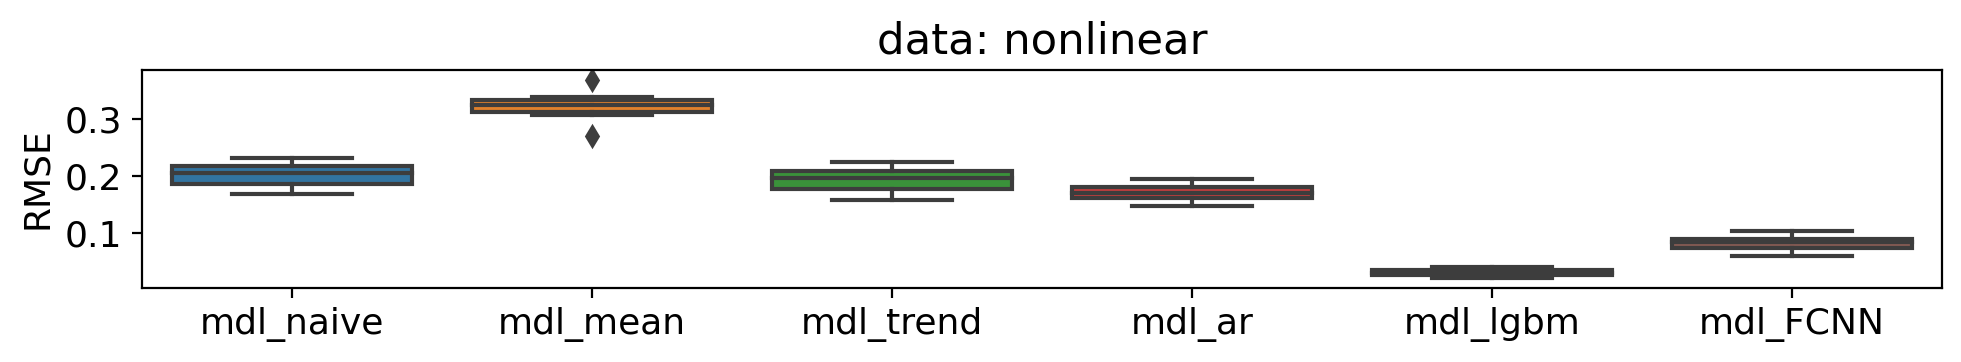

In [8]:
for dname in data_dic.keys():
    plt.figure(dpi=200, figsize=(10, 2))
    sns.boxplot(data=pd.DataFrame(rslt_all[dname]))
    plt.ylabel('RMSE')
    plt.title(f"data: {dname}")
    plt.tight_layout()